## Exercise 02
#### Agajan Torayev
<a src="https://github.com/torayeff/NLPLab">Github: @torayeff</a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pprint
%matplotlib inline

In [2]:
# global count vectorizer for data transfer between models
#count_vec = CountVectorizer()
count_vec = TfidfVectorizer(stop_words='english')

## Helper Functions

In [3]:
def plot_confusion_matrix(cm, classes):
    """Plot confusion matrix from metrics.confusion_matrix numpy.ndarray
    
    Args:
        cm: numpy.ndarray confusion matrix which is returned from metrics.confusion matrix
        classes: list of class names
    """
    if len(classes) == 2:
        # the count of true negatives is C_{0,0}, 
        # false negatives is C_{1,0}, 
        # true positives is C_{1,1}, 
        # false positives is C_{0,1}.
        classes = [classes[0]+": (- class)", classes[1]+": (+ class)"]
        
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    fig = plt.figure()
    heatmap = sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels())
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels())
    plt.xlabel("PREDICTED LABEL")
    plt.ylabel("TRUE LABEL")

def get_scores(cm):
    """Return precision, recall, accuracy, f1-score from confusion matrix.
       the count of true negatives is cm[0,0]
       the count of false negatives is cm[1, 0]
       the count of true positives is cm[1, 1]
       the count of false positives is cm[0, 1]
    
    Args:
        cm: numpy.ndarray confusion matrix which is returned from metrics.confusion matrix
    
    Returns:
        scores: dictionary of scores
    """
    tn, fp, fn, tp = cm.ravel()
    
    scores = {}
    scores['precision'] = tp/(tp + fp)
    scores['recall'] = tp/(tp + fn)
    scores['accuracy'] = (tp + tn)/(tp + tn + fp + fn)
    scores['f1'] = 2*scores['precision']*scores['recall']/(scores['precision'] + scores['recall'])
    
    return scores

def cm_scores(model, data, y_true, labels=['false', 'true']):
    """Plot confusion matrix and print scores.
    
    Args:
        model: Scipy classifier.
        data: Count vectorized data.
        y_true: True labels.
        labels: Class labels.
    """

    y_pred = model.predict(data)

    cm = metrics.confusion_matrix(y_true, y_pred, labels=labels)
    print(get_scores(cm))
    plot_confusion_matrix(cm, classes=labels)

def do_cross_val(model, X, y, n_splits=5, random_state=4222):
    """Do Cross validation and report scores.
        
    Args:
        model: Scipy classifier.
        X: vectorized data.
        y: labels.
        n_split: number of splits.
        random_state: random state.
    """
    
    fold = 1
    avg_prec = 0
    avg_recall = 0
    avg_f1 = 0
    avg_acc = 0

    skf = StratifiedKFold(n_splits=n_splits, random_state=random_state)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model_a.fit(X_train, y_train)
        y_preds = model_a.predict(X_test)

        # treat false as positive class
        precision = metrics.precision_score(y_test, y_preds, labels=['false'], average=None)[0]
        recall = metrics.recall_score(y_test, y_preds, labels=['false'], average=None)[0]
        f1 = metrics.f1_score(y_test, y_preds, labels=['false'], average=None)[0]
        accuracy = metrics.accuracy_score(y_test, y_preds)

        print("Fold #: ", fold)
        cm = metrics.confusion_matrix(y_test, y_preds, labels=['false', 'true'])
        scores = get_scores(cm)
        print(scores)
        avg_prec += scores['precision']
        avg_recall += scores['recall']
        avg_f1 += scores['f1']
        avg_acc += scores['accuracy']
        fold = fold + 1
        print("---------------------------")

    print("Average precision: ", avg_prec/n_splits)
    print("Average recall: ", avg_recall/n_splits)
    print("Average f1: ", avg_f1/n_splits)
    print("Average accuracy: ", avg_acc/n_splits)

## Configuration 1: model a => dataset1 (train / test split)

### Exploring and Preprocessing

In [4]:
df = pd.read_csv("data/fake_or_real_news.csv")
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [5]:
df.loc[df['label'] == 'REAL', 'label'] = 'true'
df.loc[df['label'] == 'FAKE', 'label'] = 'false'

In [6]:
X_ds1 = count_vec.fit_transform(df['text'])
y_ds1 = df['label']

### Building a model

In [7]:
model_a = MultinomialNB(alpha=0.05)
do_cross_val(model_a, X_ds1, y_ds1, n_splits=5, random_state=4222)

Fold #:  1
{'precision': 0.8945783132530121, 'recall': 0.9354330708661417, 'accuracy': 0.9124605678233438, 'f1': 0.9145496535796767}
---------------------------
Fold #:  2
{'precision': 0.8794642857142857, 'recall': 0.9321766561514195, 'accuracy': 0.9021310181531176, 'f1': 0.9050535987748852}
---------------------------
Fold #:  3
{'precision': 0.8729689807976366, 'recall': 0.9321766561514195, 'accuracy': 0.8981846882399369, 'f1': 0.9016018306636155}
---------------------------
Fold #:  4
{'precision': 0.875366568914956, 'recall': 0.9416403785488959, 'accuracy': 0.9037095501183899, 'f1': 0.9072948328267477}
---------------------------
Fold #:  5
{'precision': 0.8596237337192475, 'recall': 0.9369085173501577, 'accuracy': 0.891785150078989, 'f1': 0.8966037735849056}
---------------------------
Average precision:  0.8764003764798275
Average recall:  0.9356670558136069
Average f1:  0.9050207378859663
Average accuracy:  0.9016541948827556


### Fitting model with best parameters

In [8]:
model_a.fit(X_ds1, y_ds1)

MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True)

## Configuration 2) model b => dataset2 (train / validation / test split)

In [9]:
data_path = "data/liar_liar_paints_on_fire/liar_dataset/"

# read the sets into dataframes
train_df_ds2 = pd.read_csv(f'{data_path}train.tsv', sep='\t', 
                       usecols=[1, 2], names=['label', 'statement'])

valid_df_ds2 = pd.read_csv(f'{data_path}valid.tsv', sep='\t', 
                       usecols=[1, 2], names=['label', 'statement'])

test_df_ds2 = pd.read_csv(f'{data_path}test.tsv', sep='\t', 
                       usecols=[1, 2], names=['label', 'statement'])

# replace all no-true values as false
train_df_ds2.loc[train_df_ds2['label'] != 'true', 'label'] = 'false'
valid_df_ds2.loc[valid_df_ds2['label'] != 'true', 'label'] = 'false'
test_df_ds2.loc[test_df_ds2['label'] != 'true', 'label'] = 'false'

# Count vectorize
train_X_vec_ds2 = count_vec.transform(train_df_ds2['statement'])
valid_X_vec_ds2 = count_vec.transform(valid_df_ds2['statement'])
test_X_vec_ds2 = count_vec.transform(test_df_ds2['statement'])

### Building a model

In [10]:
model_b = SGDClassifier(max_iter=1000, loss='squared_hinge')
model_b.fit(train_X_vec_ds2, train_df_ds2['label'])

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='squared_hinge', max_iter=1000,
       n_iter=None, n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

### Training Set

{'precision': 0.5065055762081785, 'recall': 0.32517899761336516, 'accuracy': 0.8376953125, 'f1': 0.3960755813953489}


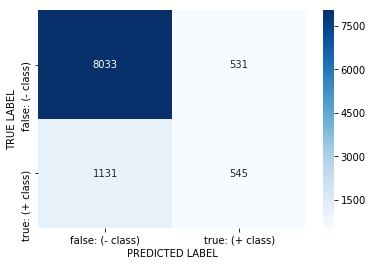

In [11]:
cm_scores(model_b, train_X_vec_ds2, train_df_ds2['label'])

### Validation Set

{'precision': 0.21052631578947367, 'recall': 0.16568047337278108, 'accuracy': 0.8084112149532711, 'f1': 0.18543046357615897}


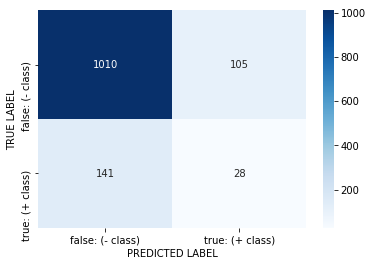

In [12]:
cm_scores(model_b, valid_X_vec_ds2, valid_df_ds2['label'])

### Test Set

{'precision': 0.20945945945945946, 'recall': 0.14903846153846154, 'accuracy': 0.7679558011049724, 'f1': 0.17415730337078653}


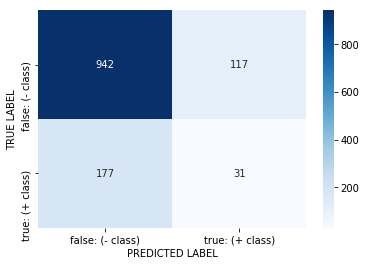

In [13]:
cm_scores(model_b, test_X_vec_ds2, test_df_ds2['label'])

## Configuration 3) model a => dataset2 | model2 => dataset1 (test)

### Model a, dataset 2

{'precision': 0.16105263157894736, 'recall': 0.7355769230769231, 'accuracy': 0.3275453827940016, 'f1': 0.26424870466321243}


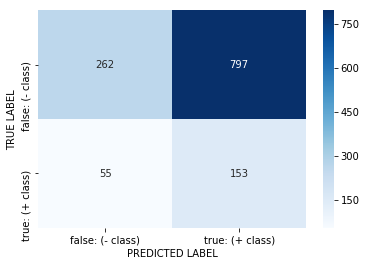

In [14]:
cm_scores(model_a, test_X_vec_ds2, test_df_ds2['label'])

### Model b, dataset 1

{'precision': 0.670196671709531, 'recall': 0.6985178177231157, 'accuracy': 0.6770323599052881, 'f1': 0.6840642371834467}


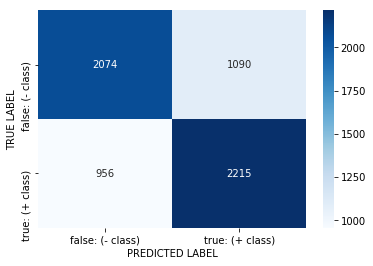

In [15]:
cm_scores(model_b, X_ds1, y_ds1)

## Configuration 4) model c => dataset3 (train / test split)

In [16]:
import random
def get_dataset3_split(dataset1_in, dataset2_in):
    """Credits https://github.com/diegoesteves
    """
    try:
        print('processing datasets')
        print('ds1=', dataset1_in)
        print('ds2=', dataset2_in)

        print('-- fake news')
        df1 = pd.read_csv(dataset1_in, sep=',', usecols=['title','text','label'])
        df1['claim'] = df1[['title', 'text']].apply(lambda x: '. '.join(x), axis=1)
        del df1['title']
        del df1['text']
        df1.rename(index=str, columns={'label': 'y'}, inplace=True)
        print(df1.keys())
        print(len(df1[df1['y']=='REAL']))
        print(len(df1[df1['y']=='FAKE']))
        df1['y'] = np.where(df1['y'] == 'FAKE', 'false', 'true')
        print(len(df1))

        print('-- liar liar')
        df2 = pd.read_csv(dataset2_in, sep='\t', header=None, usecols=[1,2], names=['y', 'claim'])
        print(df2.keys())
        print(set(df2.y), len(df2))
        print(len(df2[df2['y'] == 'true']))
        print(len(df2[df2['y'] == 'false']))
        df2=df2[(df2['y'] == 'true') | (df2['y'] == 'false')]
        print(set(df2.y), len(df2))

        df3=pd.concat([df1, df2], ignore_index=True)

        print(df3['y'].value_counts())
        print('done')
        #return train_test_split(df3['claim'], df3['y'], test_size=0.30, random_state=4222)
        return df3['claim'], df3['y']
    except Exception as e:
        print(e)


ds1 = "data/fake_or_real_news.csv"
ds2 = "data/liar_liar_paints_on_fire/liar_dataset/train.tsv"
X_ds3, y_ds3 = get_dataset3_split(ds1,ds2)

processing datasets
ds1= data/fake_or_real_news.csv
ds2= data/liar_liar_paints_on_fire/liar_dataset/train.tsv
-- fake news
Index(['y', 'claim'], dtype='object')
3171
3164
6335
-- liar liar
Index(['y', 'claim'], dtype='object')
{'true', 'half-true', 'pants-fire', 'false', 'barely-true', 'mostly-true'} 10240
1676
1995
{'false', 'true'} 3671
false    5159
true     4847
Name: y, dtype: int64
done


In [17]:
X_ds3.head()

0    You Can Smell Hillary’s Fear. Daniel Greenfiel...
1    Watch The Exact Moment Paul Ryan Committed Pol...
2    Kerry to go to Paris in gesture of sympathy. U...
3    Bernie supporters on Twitter erupt in anger ag...
4    The Battle of New York: Why This Primary Matte...
Name: claim, dtype: object

In [18]:
# vectorize
X_vec_ds3 = count_vec.transform(X_ds3)

In [19]:
model_c = RandomForestClassifier(n_estimators=50, criterion='entropy')
do_cross_val(model_a, X_vec_ds3, y_ds3, n_splits=5, random_state=4222)

Fold #:  1
{'precision': 0.9020979020979021, 'recall': 0.9309278350515464, 'accuracy': 0.9175824175824175, 'f1': 0.9162861491628616}
---------------------------
Fold #:  2
{'precision': 0.8864758144126358, 'recall': 0.9257731958762887, 'accuracy': 0.9065934065934066, 'f1': 0.9056984367120525}
---------------------------
Fold #:  3
{'precision': 0.881139489194499, 'recall': 0.9256965944272446, 'accuracy': 0.9035482258870565, 'f1': 0.902868646200302}
---------------------------
Fold #:  4
{'precision': 0.5474293989862419, 'recall': 0.7801857585139319, 'accuracy': 0.5812093953023488, 'f1': 0.643404255319149}
---------------------------
Fold #:  5
{'precision': 0.4867807153965785, 'recall': 0.6460268317853457, 'accuracy': 0.4985, 'f1': 0.555210643015521}
---------------------------
Average precision:  0.7407846640175715
Average recall:  0.8417220431308715
Average f1:  0.7846936260819771
Average accuracy:  0.761486689073046


### Fitting model with best parameters

In [20]:
model_c.fit(X_vec_ds3, y_ds3)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)